In [ ]:
import os
import numpy as np
import pandas as pd

from sqlalchemy import create_engine
from dotenv import load_dotenv

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
load_dotenv("../env/.env")

DB_URL = os.getenv("DATABASE_URL")
engine = create_engine(DB_URL)


In [ ]:
import sys
import numpy as np
import pandas as pd

print(sys.version)


In [ ]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

load_dotenv()

engine = create_engine(
    "postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}".format(
        user=os.getenv("PGUSER"),
        password=os.getenv("PGPASSWORD"),
        host=os.getenv("PGHOST"),
        port=os.getenv("PGPORT"),
        db=os.getenv("PGDATABASE"),
    )
)


In [1]:
from dotenv import load_dotenv
from pathlib import Path
import os

env_path = Path(r"C:\OneDrive\gvs-kyiv\env\.env")
print("ENV exists:", env_path.exists(), "size:", env_path.stat().st_size if env_path.exists() else None)

load_dotenv(env_path)

for k in ["PGHOST","PGPORT","PGUSER","PGPASSWORD","PGDATABASE"]:
    v = os.getenv(k)
    print(k, "=", ("***" if k=="PGPASSWORD" and v else v))


ENV exists: True size: 86
PGHOST = localhost
PGPORT = 5432
PGUSER = postgres
PGPASSWORD = ***
PGDATABASE = gvs_kyiv


In [2]:
import os
from sqlalchemy import create_engine
from urllib.parse import quote_plus

host = os.getenv("PGHOST", "localhost")
port = int(os.getenv("PGPORT", "5432"))  # тепер не None
user = os.getenv("PGUSER")
pwd  = os.getenv("PGPASSWORD")
db   = os.getenv("PGDATABASE")

assert all([user, pwd, db]), "Missing PGUSER/PGPASSWORD/PGDATABASE in .env"

url = f"postgresql+psycopg2://{user}:{quote_plus(pwd)}@{host}:{port}/{db}"
engine = create_engine(url, pool_pre_ping=True)

# quick smoke test
with engine.connect() as c:
    print(c.exec_driver_sql("select current_database(), current_user, version()").fetchone())


('gvs_kyiv', 'postgres', 'PostgreSQL 17.6 on x86_64-windows, compiled by msvc-19.44.35217, 64-bit')


In [3]:
import pandas as pd

df = pd.read_sql_query("SELECT * FROM gvs.vw_ml_land_only_glm_ready_v1;", engine)
df.shape, df.columns.tolist()[:10]


((52, 16),
 ['spatial_unit_id',
  'y_ln_uah_m2',
  'x_ln_area',
  'lon',
  'lat',
  'x_ln_dist_metro',
  'x_ln_dist_school',
  'x_ln_dist_kindergarten',
  'x_ln_dist_park',
  'x_ln_dist_water'])

In [4]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, r2_score

# target
y_log = df["y_ln_uah_m2"].astype(float)

# features (візьми всі x_* + lon/lat + gp_band_*)
feature_cols = [c for c in df.columns if c.startswith("x_")] + ["lon","lat","gp_band_1","gp_band_2","gp_band_3"]
X = df[feature_cols].astype(float)

X = sm.add_constant(X, has_constant="add")
model = sm.OLS(y_log, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            y_ln_uah_m2   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     28.05
Date:                Sun, 18 Jan 2026   Prob (F-statistic):           1.85e-15
Time:                        20:51:10   Log-Likelihood:                -40.411
No. Observations:                  52   AIC:                             110.8
Df Residuals:                      37   BIC:                             140.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -136

In [5]:
y_pred_log = model.predict(X)

# R² у log-просторі
r2_log = r2_score(y_log, y_pred_log)

# back-transform у грн/м2
y_true = np.exp(y_log)
y_pred = np.exp(y_pred_log)

mae  = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# R² в оригіналі (обережно: буде інша інтерпретація)
r2_orig = r2_score(y_true, y_pred)

r2_log, r2_orig, mae, mape


(0.9138864236303312,
 0.9183677450182752,
 31434.841470735373,
 np.float64(46.58575791130255))

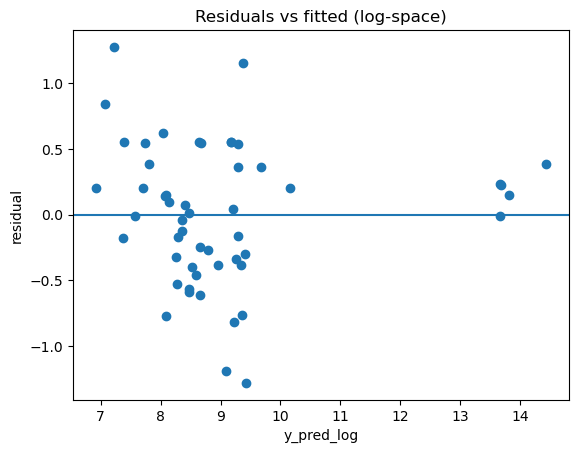

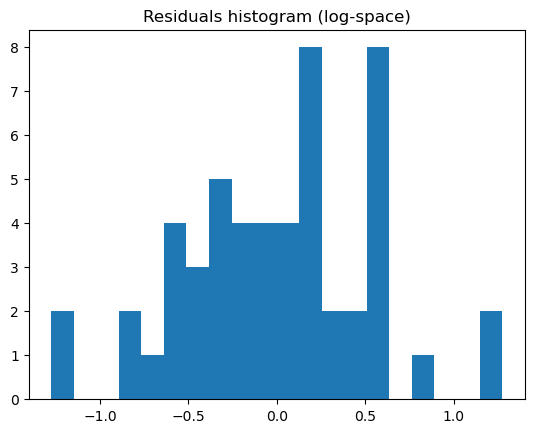

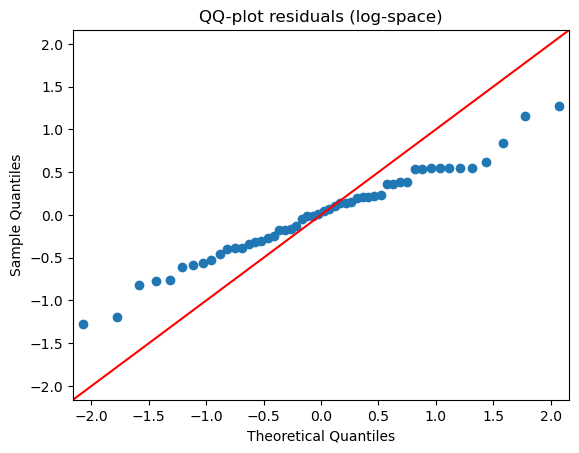

In [6]:
import matplotlib.pyplot as plt

resid = y_log - y_pred_log

plt.figure()
plt.scatter(y_pred_log, resid)
plt.axhline(0)
plt.title("Residuals vs fitted (log-space)")
plt.xlabel("y_pred_log")
plt.ylabel("residual")
plt.show()

plt.figure()
plt.hist(resid, bins=20)
plt.title("Residuals histogram (log-space)")
plt.show()

sm.qqplot(resid, line="45")
plt.title("QQ-plot residuals (log-space)")
plt.show()


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import statsmodels.api as sm

X = df[feature_cols].astype(float)
X = sm.add_constant(X, has_constant="add")
y = df["y_ln_uah_m2"].astype(float)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42
)

m_tr = sm.OLS(y_tr, X_tr).fit()
y_te_pred = m_tr.predict(X_te)

r2_log_te = r2_score(y_te, y_te_pred)

mae_orig = mean_absolute_error(
    np.exp(y_te), np.exp(y_te_pred)
)

r2_log_te, mae_orig


(0.7892250065657205, 25843.772373693893)

In [8]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

y_true_log = []
y_pred_log = []

for train_idx, test_idx in loo.split(X):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    m = sm.OLS(y_tr, X_tr).fit()
    y_hat = m.predict(X_te)

    y_true_log.append(y_te.values[0])
    y_pred_log.append(y_hat.values[0])

y_true_log = np.array(y_true_log)
y_pred_log = np.array(y_pred_log)

# metrics
r2_log_loo = r2_score(y_true_log, y_pred_log)
mae_orig_loo = mean_absolute_error(
    np.exp(y_true_log),
    np.exp(y_pred_log)
)
mape_loo = np.mean(np.abs((np.exp(y_true_log) - np.exp(y_pred_log)) / np.exp(y_true_log))) * 100

r2_log_loo, mae_orig_loo, mape_loo


(0.8038727875459033, 48939.198077979745, np.float64(69.56673453055421))

In [9]:
sm.OLS(y_log, X).fit(cov_type="HC3")
